In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from collections import Counter
from scipy.stats import norm, beta, bernoulli

In [2]:
import sys
sys.path.append("C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing")

%load_ext autoreload
%autoreload 2

In [3]:
#simple simulations
from src.simulations import SimpleSimulation
from src.simulation_melange_gaussien import GMixSimulation
from src.simulation_uniforme import UniformSimulation
#simulations with context
from src.context_generator import ContextGenerator
from src.simulation_with_context import ContextualDemandSimulation
#bandit algo
from src.binomial_bandit import BinomialBandit
from src.simple_bandit_greedy import GreedyBandit
from src.simple_bandit_ucb import UCBBandit
from src.context_bandit import ContextBandit
#evaluation algo (regret)
from src.evaluate_model import EvaluateBandit
from src.evaluate_with_context import EvaluateBanditContext

In [4]:
def plot_demand(simulation, min_price = 0, max_price = 150, n_points = 50, n_estimates_per_point = 40) : 
    prices = []
    revenues = []
    for price in np.linspace(min_price, max_price, n_points) : 
        revenues.extend( [int(simulation.evaluate(price)) * price for x in range(n_estimates_per_point)] )
        prices.extend([price for x in range(n_estimates_per_point)])
    
    a = np.array([prices, revenues])

    fig = plt.figure(figsize = (15,6), facecolor="w")
    ax = sns.lineplot(a[0], a[1])
    ax.legend("")

In [5]:
def test_bandit_thompson(simulation,k_p, alpha_0, beta_0,init_round=10,test_round=5000):
    hist = []
    regret = []
    reward_T = []
    parameters=np.array([np.array([alpha_0]),np.array([beta_0])])
    bandit = BinomialBandit(k_p, alpha_0, beta_0)
    evaluation=EvaluateBandit(bandit,simulation)
    print(evaluation.best_price)
    # Exploration round
    for i in range(init_round):
        for j in range(bandit.k):
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price)) * price
            bandit.update(bandit.action, reward)
            regret.append(evaluation.get_regret(bandit.n_obs))
            parameters = np.append(parameters,np.array([np.array([bandit.alpha_n]),np.array([bandit.beta_n])]),axis=1)

    for i in range(test_round):
        bandit.chose_action(method="thompson")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price)) * price
        bandit.update(bandit.action, reward)
        regret.append(evaluation.get_regret(bandit.n_obs))
        hist.append(k_p[bandit.action])
        parameters = np.append(parameters,np.array([np.array([bandit.alpha_n]),np.array([bandit.beta_n])]),axis=1)
    return hist,regret,parameters

In [6]:
def test_bandit_greedy(simulation,k_p,c,d,init_round=10,test_round=5000):
    hist = []
    regret = []
    reward_T = []
    bandit = GreedyBandit(k_p, d,c)
    evaluation=EvaluateBandit(bandit,simulation)
    # Exploration round
    for i in range(init_round):
        for j in range(bandit.k):
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price)) * price
            regret.append(evaluation.get_regret(bandit.n_obs))
            bandit.update(bandit.action, reward)

    for i in range(test_round):
        bandit.chose_action(method="greedy")
        price = k_p[bandit.action]
        reward = int(simulation.evaluate(price)) * price
        regret.append(evaluation.get_regret(bandit.n_obs))
        bandit.update(bandit.action, reward)
        hist.append(k_p[bandit.action])
        
    return hist,regret

In [7]:
def test_bandit_ucb(simulation,k_p,init_round=10,test_round=5000):
    hist = []
    regret = []
    reward_T = []
    B_stocked=[]
    bandit = UCBBandit(k_p)
    evaluation=EvaluateBandit(bandit,simulation)
    # Exploration round
    for i in range(init_round):
        for j in range(bandit.k):
            bandit.chose_action(force_action=j)
            price = k_p[bandit.action]
            reward = int(simulation.evaluate(price)) * price
            regret.append(evaluation.get_regret(bandit.n_obs))
            bandit.update(bandit.action, reward)
            

    for i in range(test_round):
        bandit.chose_action(method="ucb")
        price = k_p[bandit.action]
        B_stocked.append(bandit.B)
        reward = int(simulation.evaluate(price)) * price
        bandit.update(bandit.action, reward)
        regret.append(evaluation.get_regret(bandit.n_obs))
        hist.append(k_p[bandit.action])
        
    return hist,regret,B_stocked

# Simulations

In [8]:
sim_u = UniformSimulation(35,75)
sim_u.optimal_price

37.499969482421875

In [9]:
sim_nl= SimpleSimulation(40,20)
sim_nl.optimal_price

33.3662109375

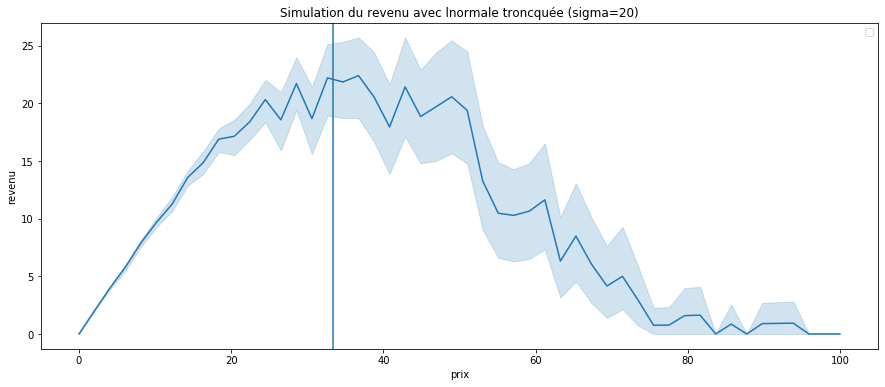

In [10]:
plot_demand(sim_nl,max_price = 100,n_estimates_per_point = 100)
plt.axvline(x=sim_nl.optimal_price)
plt.title('Simulation du revenu avec lnormale troncquée (sigma=20)')
plt.xlabel('prix')
plt.ylabel('revenu')
plt.savefig('demand_normale_gde.png')

In [11]:
sim_ns= SimpleSimulation(40,6)
sim_ns.optimal_price

32.13543701171875

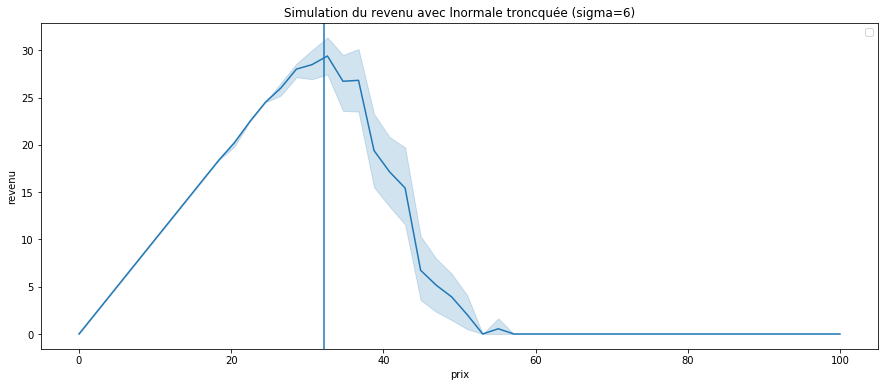

In [12]:
plot_demand(sim_ns,max_price = 100,n_estimates_per_point = 100)
plt.axvline(x=sim_ns.optimal_price)
plt.title('Simulation du revenu avec lnormale troncquée (sigma=6)')
plt.xlabel('prix')
plt.ylabel('revenu')
plt.savefig('demand_normale_pt.png')

In [13]:
sim_mix= GMixSimulation(30,2,70,10,0.5)
sim_mix.optimal_price

56.534423828125

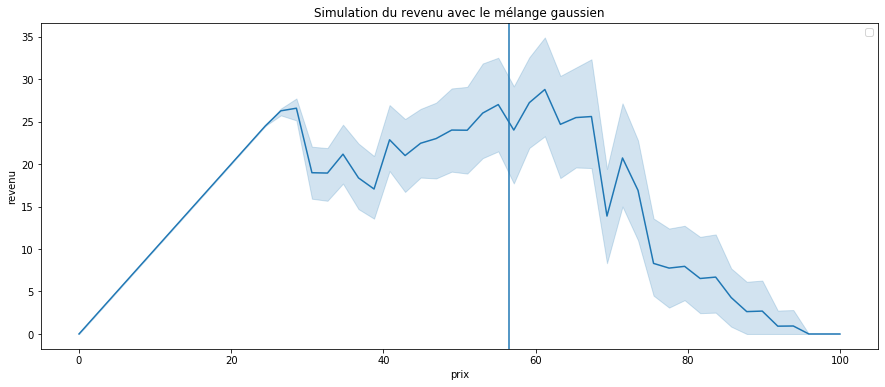

In [14]:
plot_demand(sim_mix,max_price = 100,n_estimates_per_point = 100)
plt.axvline(x=sim_mix.optimal_price)
plt.title('Simulation du revenu avec le mélange gaussien')
plt.xlabel('prix')
plt.ylabel('revenu')
plt.savefig('demand_mix.png')


# Comparaisons des algorithmes

### Avec la loi uniforme

In [15]:
size = 7
k_p = np.linspace(5,120,size)

In [16]:
c = 5
d = 3
greedy_uniform_1=test_bandit_greedy(sim_u,k_p, c, d,init_round=0,test_round=5000)
greedy_uniform_2=test_bandit_greedy(sim_u,k_p, c, d,init_round=10,test_round=5000)

BinomialBandit model for espilon-greedy instanciated with 7 arms.


C:/Users/clementine.rosier/OneDrive - Ekimetrics/Documents/GitHub/dynamic_pricing\src\simple_bandit_greedy.py:65: RuntimeWarning: invalid value encountered in true_divide
  average_reward = self.k_p*np.nan_to_num(self.n_pos/(self.n_obs))


BinomialBandit model for espilon-greedy instanciated with 7 arms.


In [17]:
alpha_0 = np.repeat(1,size)
beta_0 = np.repeat(1,size)
thompson_uniform_1=test_bandit_thompson(sim_u,k_p, alpha_0, beta_0,init_round=0,test_round=5000)
thompson_uniform_2=test_bandit_thompson(sim_u,k_p, alpha_0, beta_0,init_round=10,test_round=5000)

BinomialBandit model instanciated with 7 arms.
43.333333333333336
BinomialBandit model instanciated with 7 arms.
43.333333333333336


In [18]:
ucb_uniform_1=test_bandit_ucb(sim_u,k_p,init_round=0,test_round=5000)
ucb_uniform_2=test_bandit_ucb(sim_u,k_p,init_round=10,test_round=5000)

BinomialBandit model for UCB instanciated with 7 arms.
BinomialBandit model for UCB instanciated with 7 arms.


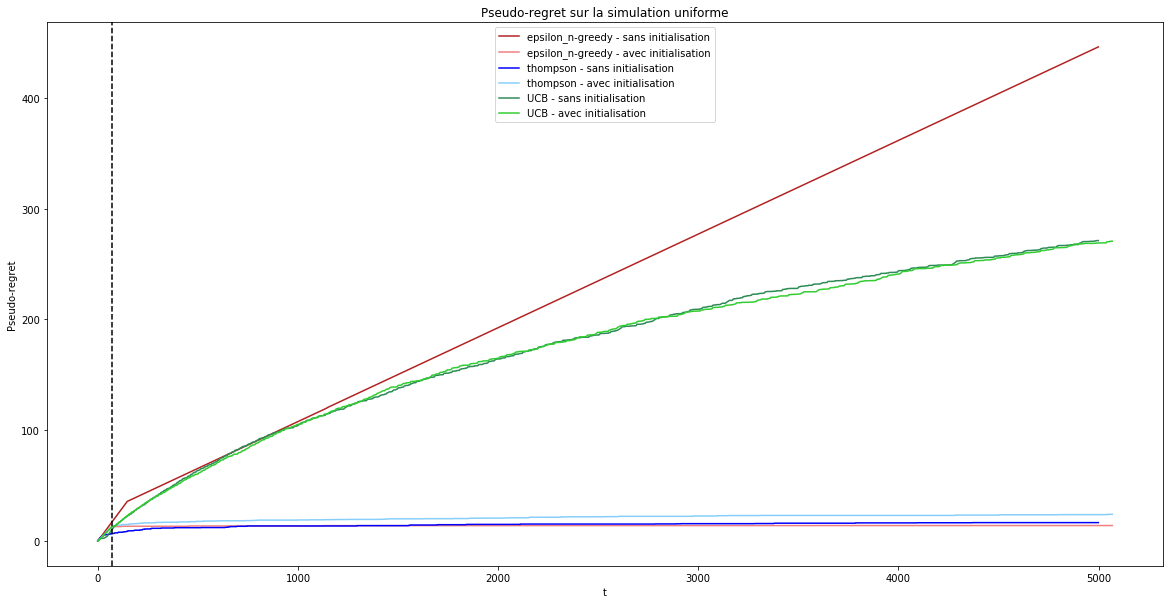

In [23]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(greedy_uniform_1[1],c='firebrick')
plt.plot(greedy_uniform_2[1],c='lightcoral')
plt.plot(thompson_uniform_1[1],c='blue')
plt.plot(thompson_uniform_2[1],c='lightskyblue')
plt.plot(ucb_uniform_1[1],c='seagreen')
plt.plot(ucb_uniform_2[1],c='limegreen')
plt.title('Pseudo-regret sur la simulation uniforme')
plt.ylabel('Pseudo-regret')
plt.xlabel('t')
plt.axvline(x=70,c='black',linestyle='dashed')
plt.legend(("epsilon_n-greedy - sans initialisation","epsilon_n-greedy - avec initialisation","thompson - sans initialisation","thompson - avec initialisation","UCB - sans initialisation","UCB - avec initialisation"))
plt.savefig('comparaison_uniform_v2.png')

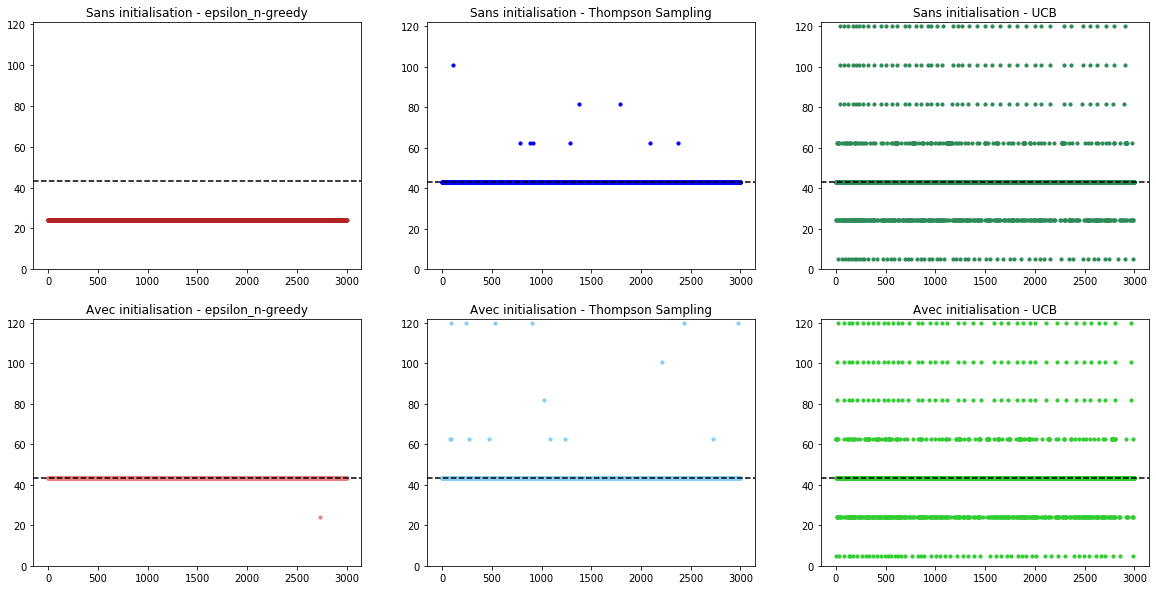

In [21]:
time=range(3000)
plt.title('Prix joués lors des 3000 derniers tirages')
plt.subplot(2,3,1)
plt.scatter(time,greedy_uniform_1[0][2000:5000],c='firebrick',s=10)
plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
plt.ylim(0,121)
plt.title('Sans initialisation - epsilon_n-greedy')
plt.subplot(2,3,2)
plt.scatter(time,thompson_uniform_1[0][2000:5000],c='blue',s=10)
plt.axhline(y=43.3333333333333368,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Sans initialisation - Thompson Sampling')
plt.subplot(2,3,3)
plt.scatter(time,ucb_uniform_1[0][2000:5000],c='seagreen',s=10)
plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Sans initialisation - UCB')
plt.subplot(2,3,4)
plt.scatter(time,greedy_uniform_2[0][2000:5000],c='lightcoral',s=10)
plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - epsilon_n-greedy')
plt.subplot(2,3,5)
plt.scatter(time,thompson_uniform_2[0][2000:5000],c='lightskyblue',s=10)
plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - Thompson Sampling')
plt.subplot(2,3,6)
plt.scatter(time,ucb_uniform_2[0][2000:5000],c='limegreen',s=10)
plt.axhline(y=43.333333333333336,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - UCB')
plt.savefig('prix_comparaison_uniform_v2.png')

In [20]:
#avec les lois normales troncquées

In [22]:
c = 5
d = 3
greedy_nl_1=test_bandit_greedy(sim_nl,k_p, c, d,init_round=0,test_round=5000)
greedy_nl_2=test_bandit_greedy(sim_nl,k_p, c, d,init_round=10,test_round=5000)
alpha_0 = np.repeat(1,size)
beta_0 = np.repeat(1,size)
thompson_nl_1=test_bandit_thompson(sim_nl,k_p, alpha_0, beta_0,init_round=0,test_round=5000)
thompson_nl_2=test_bandit_thompson(sim_nl,k_p, alpha_0, beta_0,init_round=10,test_round=5000)
ucb_nl_1=test_bandit_ucb(sim_nl,k_p,init_round=0,test_round=5000)
ucb_nl_2=test_bandit_ucb(sim_nl,k_p,init_round=10,test_round=5000)

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model instanciated with 7 arms.
24.166666666666668
BinomialBandit model instanciated with 7 arms.
24.166666666666668
BinomialBandit model for UCB instanciated with 7 arms.
BinomialBandit model for UCB instanciated with 7 arms.


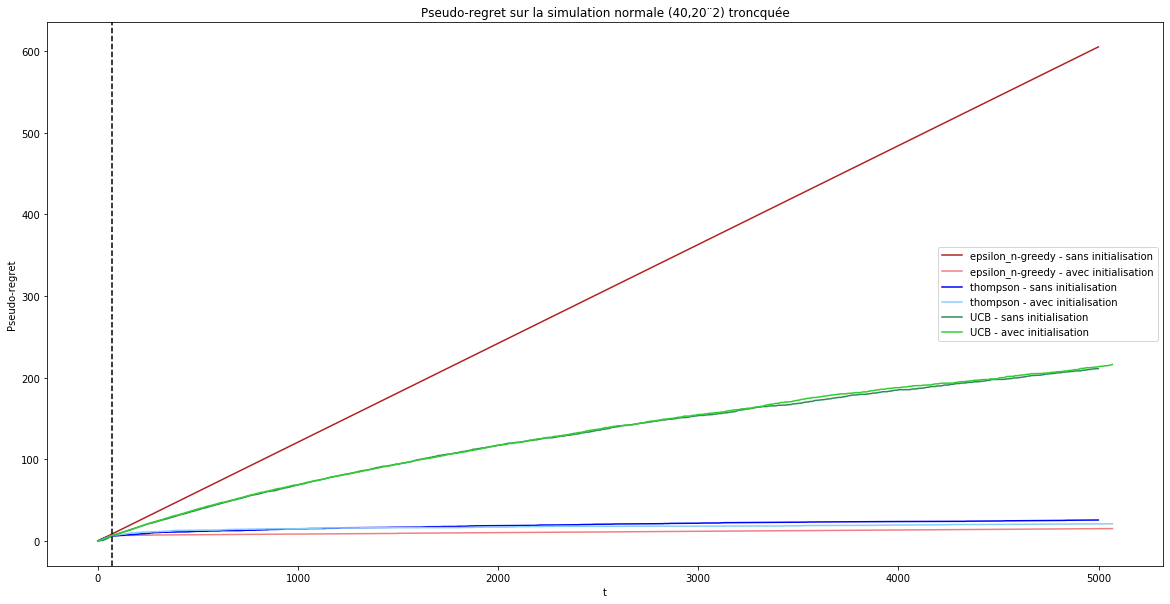

In [24]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(greedy_nl_1[1],c='firebrick')
plt.plot(greedy_nl_2[1],c='lightcoral')
plt.plot(thompson_nl_1[1],c='blue')
plt.plot(thompson_nl_2[1],c='lightskyblue')
plt.plot(ucb_nl_1[1],c='seagreen')
plt.plot(ucb_nl_2[1],c='limegreen')
plt.title('Pseudo-regret sur la simulation normale (40,20¨2) troncquée')
plt.ylabel('Pseudo-regret')
plt.xlabel('t')
plt.axvline(x=70,c='black',linestyle='dashed')
plt.legend(("epsilon_n-greedy - sans initialisation","epsilon_n-greedy - avec initialisation","thompson - sans initialisation","thompson - avec initialisation","UCB - sans initialisation","UCB - avec initialisation"))
plt.savefig('comparaison_nl_v2.png')

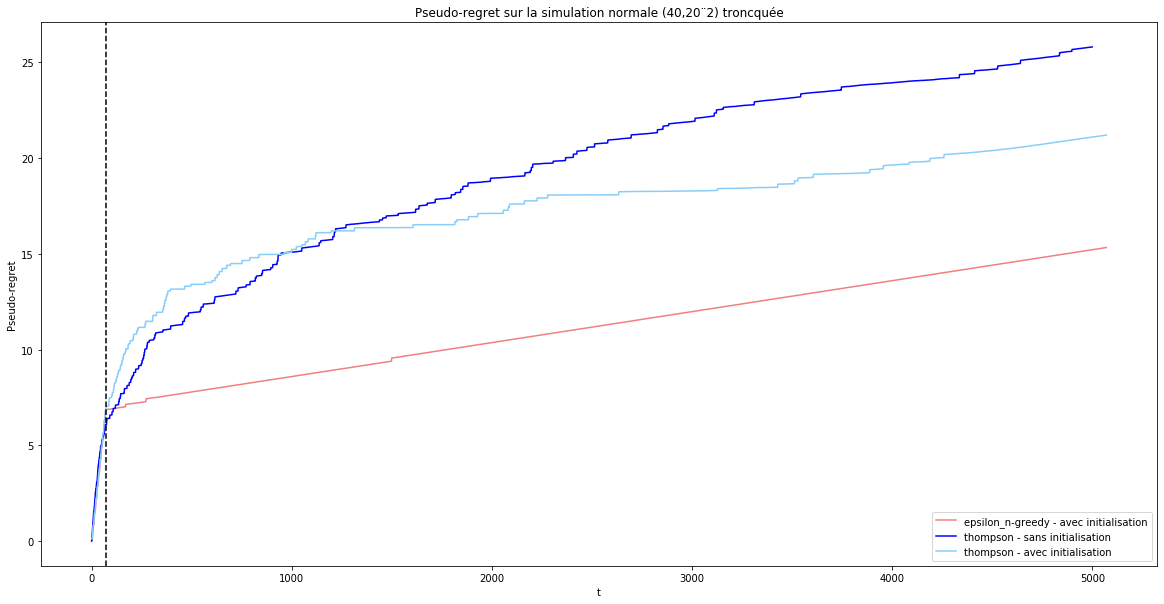

In [26]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(greedy_nl_1[1],c='firebrick')
plt.plot(greedy_nl_2[1],c='lightcoral')
plt.plot(thompson_nl_1[1],c='blue')
plt.plot(thompson_nl_2[1],c='lightskyblue')
plt.title('Pseudo-regret sur la simulation normale (40,20¨2) troncquée')
plt.ylabel('Pseudo-regret')
plt.xlabel('t')
plt.axvline(x=70,c='black',linestyle='dashed')
plt.legend(("epsilon_n-greedy - sans initialisation","epsilon_n-greedy - avec initialisation","thompson - sans initialisation","thompson - avec initialisation"))
plt.savefig('comparaison_nl_zoom.png')

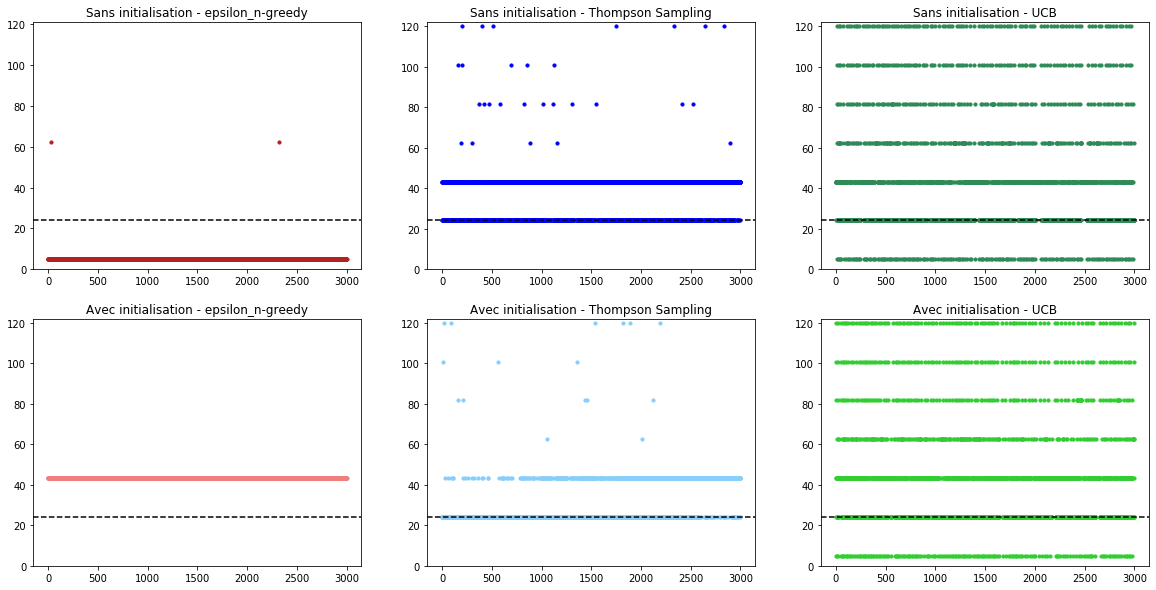

In [27]:
optimal_price = 24.166666666666668
time=range(3000)
plt.title('Prix joués lors des 3000 derniers tirages')
plt.subplot(2,3,1)
plt.scatter(time,greedy_nl_1[0][2000:5000],c='firebrick',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,121)
plt.title('Sans initialisation - epsilon_n-greedy')
plt.subplot(2,3,2)
plt.scatter(time,thompson_nl_1[0][2000:5000],c='blue',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Sans initialisation - Thompson Sampling')
plt.subplot(2,3,3)
plt.scatter(time,ucb_nl_1[0][2000:5000],c='seagreen',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Sans initialisation - UCB')
plt.subplot(2,3,4)
plt.scatter(time,greedy_nl_2[0][2000:5000],c='lightcoral',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - epsilon_n-greedy')
plt.subplot(2,3,5)
plt.scatter(time,thompson_nl_2[0][2000:5000],c='lightskyblue',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - Thompson Sampling')
plt.subplot(2,3,6)
plt.scatter(time,ucb_nl_2[0][2000:5000],c='limegreen',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - UCB')
plt.savefig('prix_comparaison_nl_v2.png')

In [28]:
c = 5
d = 3
greedy_ns_1=test_bandit_greedy(sim_ns,k_p, c, d,init_round=0,test_round=5000)
greedy_ns_2=test_bandit_greedy(sim_ns,k_p, c, d,init_round=10,test_round=5000)
alpha_0 = np.repeat(1,size)
beta_0 = np.repeat(1,size)
thompson_ns_1=test_bandit_thompson(sim_ns,k_p, alpha_0, beta_0,init_round=0,test_round=5000)
thompson_ns_2=test_bandit_thompson(sim_ns,k_p, alpha_0, beta_0,init_round=10,test_round=5000)
ucb_ns_1=test_bandit_ucb(sim_ns,k_p,init_round=0,test_round=5000)
ucb_ns_2=test_bandit_ucb(sim_ns,k_p,init_round=10,test_round=5000)

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model instanciated with 7 arms.
24.166666666666668
BinomialBandit model instanciated with 7 arms.
24.166666666666668
BinomialBandit model for UCB instanciated with 7 arms.
BinomialBandit model for UCB instanciated with 7 arms.


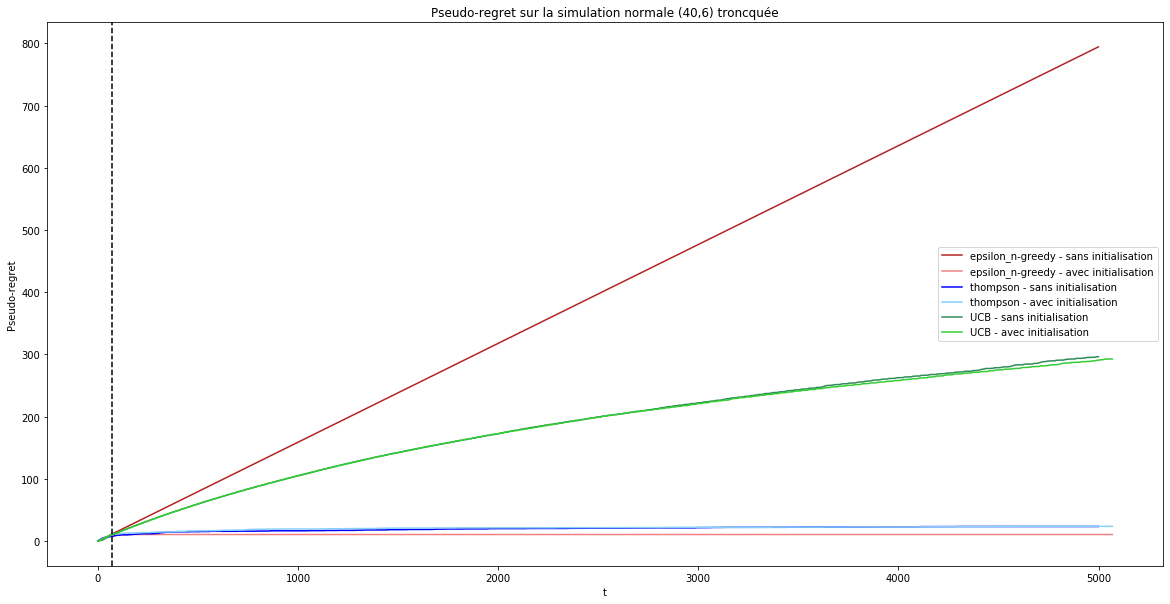

In [29]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(greedy_ns_1[1],c='firebrick')
plt.plot(greedy_ns_2[1],c='lightcoral')
plt.plot(thompson_ns_1[1],c='blue')
plt.plot(thompson_ns_2[1],c='lightskyblue')
plt.plot(ucb_ns_1[1],c='seagreen')
plt.plot(ucb_ns_2[1],c='limegreen')
plt.title('Pseudo-regret sur la simulation normale (40,6) troncquée')
plt.ylabel('Pseudo-regret')
plt.xlabel('t')
plt.axvline(x=70,c='black',linestyle='dashed')
plt.legend(("epsilon_n-greedy - sans initialisation","epsilon_n-greedy - avec initialisation","thompson - sans initialisation","thompson - avec initialisation","UCB - sans initialisation","UCB - avec initialisation"))
plt.savefig('comparaison_ns_v2.png')

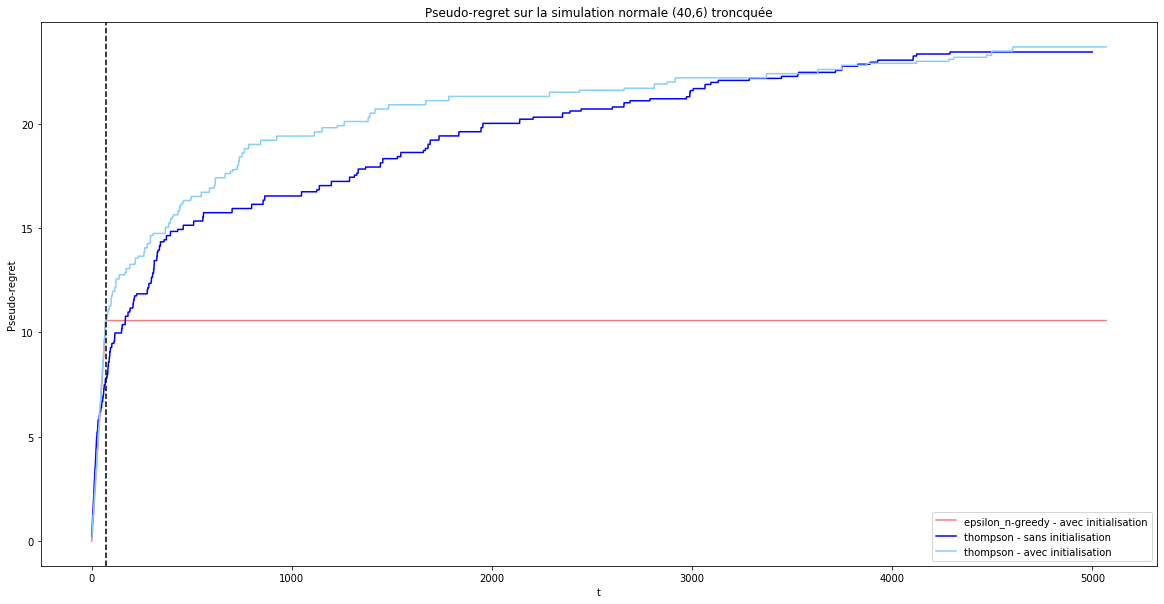

In [30]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(greedy_ns_2[1],c='lightcoral')
plt.plot(thompson_ns_1[1],c='blue')
plt.plot(thompson_ns_2[1],c='lightskyblue')
plt.title('Pseudo-regret sur la simulation normale (40,6) troncquée')
plt.ylabel('Pseudo-regret')
plt.xlabel('t')
plt.axvline(x=70,c='black',linestyle='dashed')
plt.legend(("epsilon_n-greedy - avec initialisation","thompson - sans initialisation","thompson - avec initialisation"))
plt.savefig('comparaison_ns_zoom.png')

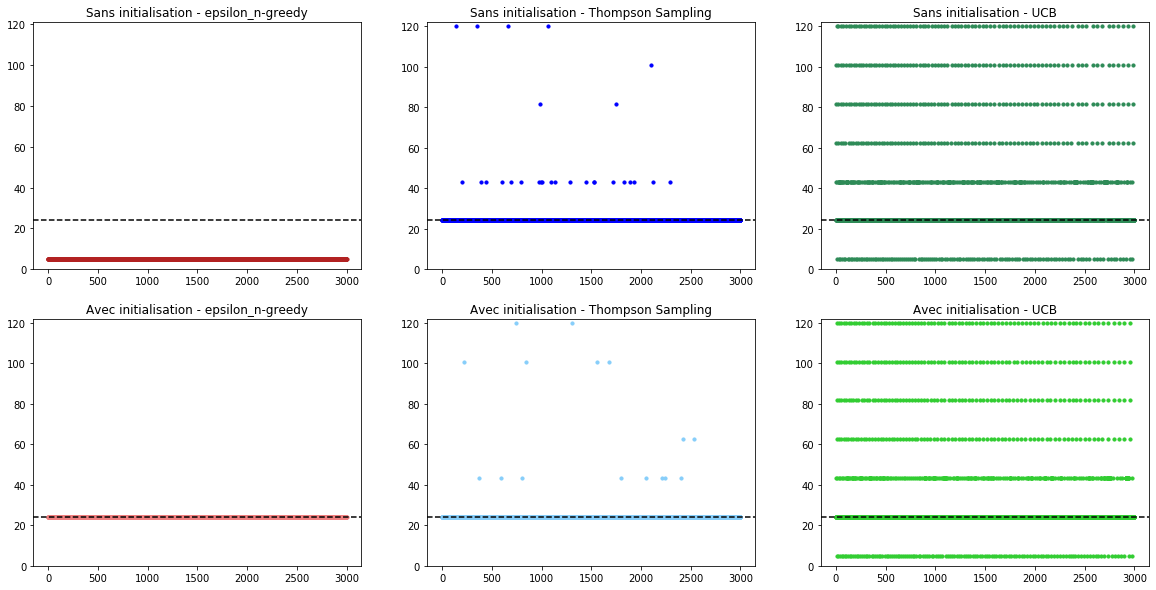

In [31]:
optimal_price = 24.166666666666668
time=range(3000)
plt.title('Prix joués lors des 3000 derniers tirages')
plt.subplot(2,3,1)
plt.scatter(time,greedy_ns_1[0][2000:5000],c='firebrick',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,121)
plt.title('Sans initialisation - epsilon_n-greedy')
plt.subplot(2,3,2)
plt.scatter(time,thompson_ns_1[0][2000:5000],c='blue',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Sans initialisation - Thompson Sampling')
plt.subplot(2,3,3)
plt.scatter(time,ucb_ns_1[0][2000:5000],c='seagreen',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Sans initialisation - UCB')
plt.subplot(2,3,4)
plt.scatter(time,greedy_ns_2[0][2000:5000],c='lightcoral',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - epsilon_n-greedy')
plt.subplot(2,3,5)
plt.scatter(time,thompson_ns_2[0][2000:5000],c='lightskyblue',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - Thompson Sampling')
plt.subplot(2,3,6)
plt.scatter(time,ucb_ns_2[0][2000:5000],c='limegreen',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - UCB')
plt.savefig('prix_comparaison_ns_v2.png')

### avec le mix gaussien

In [34]:
c = 5
d = 3
greedy_mix_1=test_bandit_greedy(sim_mix,k_p, c, d,init_round=0,test_round=5000)
greedy_mix_2=test_bandit_greedy(sim_mix,k_p, c, d,init_round=10,test_round=5000)
alpha_0 = np.repeat(1,size)
beta_0 = np.repeat(1,size)
thompson_mix_1=test_bandit_thompson(sim_mix,k_p, alpha_0, beta_0,init_round=0,test_round=5000)
thompson_mix_2=test_bandit_thompson(sim_mix,k_p, alpha_0, beta_0,init_round=10,test_round=5000)
ucb_mix_1=test_bandit_ucb(sim_mix,k_p,init_round=0,test_round=5000)
ucb_mix_2=test_bandit_ucb(sim_mix,k_p,init_round=10,test_round=5000)

BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model for espilon-greedy instanciated with 7 arms.
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model instanciated with 7 arms.
62.5
BinomialBandit model for UCB instanciated with 7 arms.
BinomialBandit model for UCB instanciated with 7 arms.


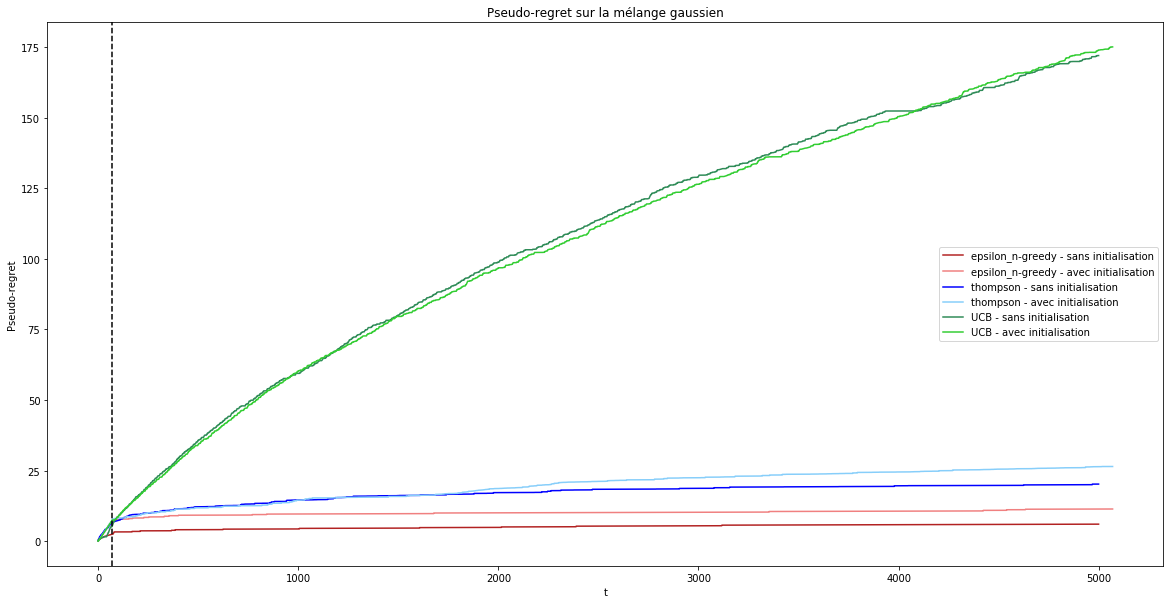

In [35]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(greedy_mix_1[1],c='firebrick')
plt.plot(greedy_mix_2[1],c='lightcoral')
plt.plot(thompson_mix_1[1],c='blue')
plt.plot(thompson_mix_2[1],c='lightskyblue')
plt.plot(ucb_mix_1[1],c='seagreen')
plt.plot(ucb_mix_2[1],c='limegreen')
plt.title('Pseudo-regret sur la mélange gaussien')
plt.ylabel('Pseudo-regret')
plt.xlabel('t')
plt.axvline(x=70,c='black',linestyle='dashed')
plt.legend(("epsilon_n-greedy - sans initialisation","epsilon_n-greedy - avec initialisation","thompson - sans initialisation","thompson - avec initialisation","UCB - sans initialisation","UCB - avec initialisation"))
plt.savefig('comparaison_mix.png')

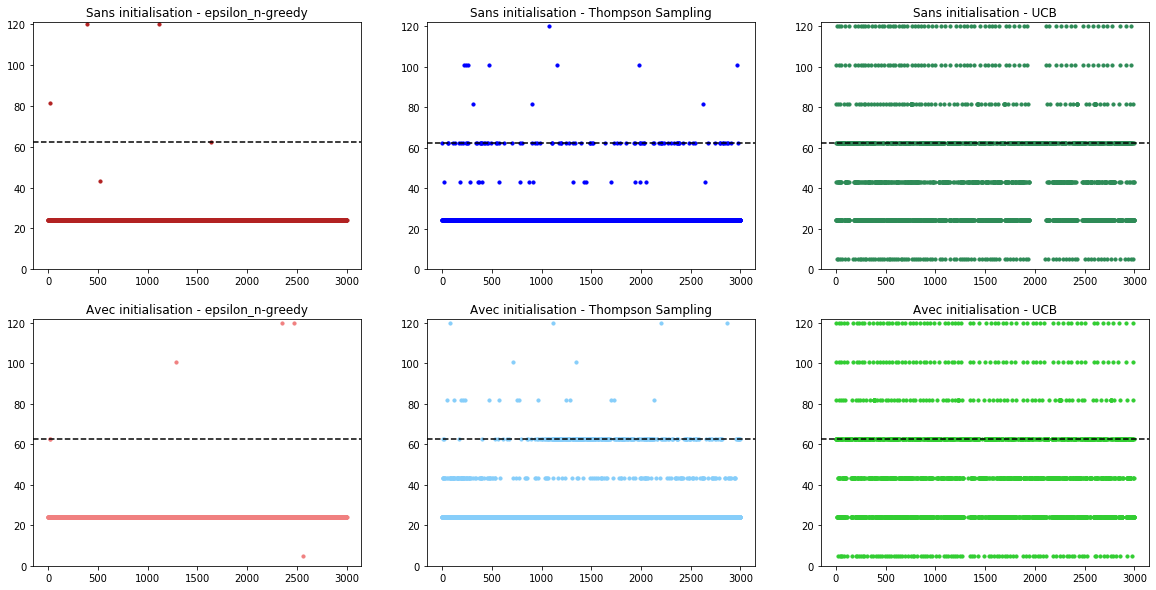

In [36]:
optimal_price = 62.5
time=range(3000)
plt.title('Prix joués lors des 3000 derniers tirages')
plt.subplot(2,3,1)
plt.scatter(time,greedy_mix_1[0][2000:5000],c='firebrick',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,121)
plt.title('Sans initialisation - epsilon_n-greedy')
plt.subplot(2,3,2)
plt.scatter(time,thompson_mix_1[0][2000:5000],c='blue',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Sans initialisation - Thompson Sampling')
plt.subplot(2,3,3)
plt.scatter(time,ucb_mix_1[0][2000:5000],c='seagreen',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Sans initialisation - UCB')
plt.subplot(2,3,4)
plt.scatter(time,greedy_mix_2[0][2000:5000],c='lightcoral',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - epsilon_n-greedy')
plt.subplot(2,3,5)
plt.scatter(time,thompson_mix_2[0][2000:5000],c='lightskyblue',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - Thompson Sampling')
plt.subplot(2,3,6)
plt.scatter(time,ucb_mix_2[0][2000:5000],c='limegreen',s=10)
plt.axhline(y=optimal_price,c='black',linestyle='dashed')
plt.ylim(0,122)
plt.title('Avec initialisation - UCB')
plt.savefig('prix_comparaison_mix.png')